In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import gym
import pathlib
import typing as tp
from scipy.special import softmax
import pandas as pd

In [3]:
!pwd

/mnt/ubuntu_data_hdd/school/masters/uwaterloo/1b/cs885/project/codenames/codenames_ai/notebooks/experimental


In [4]:
pathlib.Path("./src/").resolve()

PosixPath('/mnt/ubuntu_data_hdd/school/masters/uwaterloo/1b/cs885/project/codenames/codenames_ai/notebooks/experimental/src')

In [5]:
sys.path.insert(0, '/mnt/ubuntu_data_hdd/school/masters/uwaterloo/1b/cs885/project/codenames/codenames_ai/src')

In [6]:
from default_game import *
from codenames import *

[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-11-18 17:23:48.584307: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 53044
2022-11-18 17:23:50.054982: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 1.470623489s.
[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 43:11: text format contains deprecated field "min_cluster_size"
2022-11-18 17:24:03.682086: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 47240
2022-11-18 17:24:05.000138: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 1.318003004s.


In [7]:
board.bag_state()

{'ASSASSIN': {'IRON'},
 'BLUE': {'LAP'},
 'BYSTANDER': {'ATLANTIS'},
 'RED': {'SCUBA DIVER'}}

In [8]:
view.spymaster_view()

[['LAP_BL' 'ATLANTIS_BY']
 ['IRON_AS' 'SCUBA DIVER_RE']]
It is BLUE's turn.


In [9]:
board.jump_to_random_state()

In [10]:
board.reset_game()

In [11]:
guesser.board_vectors

array([[ 0.06517141,  0.03295911, -0.03899578, ..., -0.0582769 ,
         0.0792063 , -0.09123337],
       [ 0.0797333 , -0.09954641,  0.05793308, ..., -0.06460299,
        -0.10032429,  0.08915829],
       [-0.00137182,  0.00636226,  0.00139497, ..., -0.08836597,
        -0.06429217,  0.05859531],
       [ 0.07003275, -0.00491656, -0.00575322, ...,  0.07092778,
         0.04953808, -0.04238456]], dtype=float32)

In [12]:
def resize_token_vector(vector, limit):
    """Resize a 1D token vector to a given length, padding with "0" when necessary."""
    vector = vector[:limit]
    return np.pad(vector, (0, limit-vector.shape[0]))

In [13]:
resize_token_vector(np.array(['BIRD', 'GROUND', 'BUILD']), 3)

array(['BIRD', 'GROUND', 'BUILD'], dtype='<U6')

In [14]:
resize_token_vector(np.array(['BIRD', 'GROUND', 'BUILD']), 4)

array(['BIRD', 'GROUND', 'BUILD', '0'], dtype='<U6')

In [15]:
resize_token_vector(np.array(['BIRD', 'GROUND', 'BUILD']), 2)

array(['BIRD', 'GROUND'], dtype='<U6')

In [16]:
def generate_candidates(targets: tp.Sequence[str], limit: int):
    mean_candidates = guesser.give_hint_candidates(targets, strategy="mean")[0]
    minimax_candidates = guesser.give_hint_candidates(targets, strategy="minimax")[0]
    all_candidates = np.concatenate([
        resize_token_vector(mean_candidates, limit),
        resize_token_vector(minimax_candidates, limit),
    ])
    return all_candidates

In [17]:
generate_candidates(["turkey", "nest"], 3)

array(['NEST', 'TURKEY', 'NESTS', 'BIRD', 'SEA', 'GROUND'], dtype='<U68')

In [18]:
guesser.give_hint_candidates(["turkey", "nest"], strategy="minimax")

(array(['BIRD', 'SEA', 'GROUND', 'BUILD', 'BIRDS', 'LARGE', 'INSIDE',
        'LEAVE', 'CHICKENS', 'CHICKEN'], dtype='<U68'),
 array([0.29796296, 0.27114794, 0.26066473, 0.24819808, 0.23867956,
        0.23817247, 0.23707423, 0.23084365, 0.23036703, 0.22719172],
       dtype=float32))

In [32]:
guesser.give_hint_candidates(["turkey", "nest"], strategy="mean")

(array(['NEST', 'TURKEY', 'NESTS', 'EGGS', 'ANKARA', 'TURKISH', 'BIRDS',
        'NESTING', 'BIRD', 'EGG'], dtype='<U68'),
 array([0.5506865 , 0.5506864 , 0.41028476, 0.37161985, 0.36334908,
        0.3618063 , 0.35904393, 0.33748683, 0.31771627, 0.31606936],
       dtype=float32))

In [20]:
def find_x_in_y(x, y):
    # https://stackoverflow.com/a/8251757
    x = np.array(x)
    index = np.argsort(x)
    sorted_x = x[index]
    sorted_index = np.searchsorted(sorted_x, y)
    y_index = np.take(index, sorted_index, mode="clip")
    return y_index[x[y_index] == y]

In [21]:
# Test
find_x_in_y(np.array(['auto', 5, 6, 10, 1]), np.array([10, 5, 5, 1, 'auto', 6, 'auto', 1, 5, 10, 10, 'auto']))

array([3, 1, 1, 4, 0, 2, 0, 4, 1, 3, 3, 0])

In [22]:
find_x_in_y(np.array(['COLD', 'NIGHT', 'DAY', 'PASTE', 'LINE', 'HORSE', 'PART', 'SHOE',
       'LIFE']), np.array(['COLD', 'NIGHT', 'PART']))

array([0, 1, 6])

In [23]:
find_x_in_y(np.array(['COLD', 'NIGHT', 'DAY', 'PASTE', 'LINE', 'HORSE', 'PART', 'SHOE',
       'LIFE']), np.array(['COLD', 'NIGHT', 'PART'])[::-1], )

array([6, 1, 0])

In [24]:
np.where(np.in1d(['COLD', 'NIGHT', 'PART'][::-1], ['COLD', 'NIGHT', 'DAY', 'PASTE', 'LINE', 'HORSE', 'PART', 'SHOE',
       'LIFE']))[0]

array([0, 1, 2])

In [28]:
Hint("OTTAWA", 25, "BLUE")

Hint(word='OTTAWA', count=25, team='BLUE', num_guessed=0, num_guessed_correctly=0)

In [35]:
board.bag_state()

{'ASSASSIN': {'IRON'},
 'BLUE': {'LAP'},
 'BYSTANDER': {'ATLANTIS'},
 'RED': {'SCUBA DIVER'}}

In [39]:
guess = guesser.guess(Hint("METAL", 25, "BLUE"))
print(guess)
softmax(guess[1]*20)

(array(['IRON'], dtype='<U11'), array([0.60893506], dtype=float32))


array([1.], dtype=float32)

In [26]:
guess_softmax = np.random.choice(guess[0], 3, p=softmax(guess[1]*20), replace=False)

In [27]:
guess_softmax

array(['BACK', 'SCHOOL', 'FACE'], dtype='<U11')

In [42]:
batched_cosine_similarity(
    glove.vectorize(generate_candidates(["night", "horse"], 10)),
    guesser.board_vectors
).shape

(20, 4)

In [43]:
self_similarity = batched_cosine_similarity(
    guesser.board_vectors,
    guesser.board_vectors
)

<AxesSubplot: >

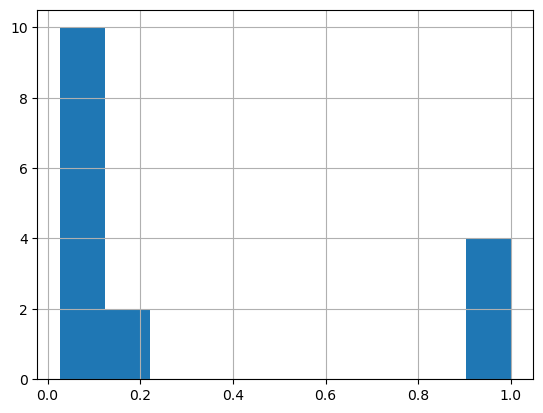

In [44]:
pd.Series(self_similarity.flatten()).hist()

In [45]:
my_team = "RED"

In [46]:
opponent_team = "BLUE"

In [47]:
board.orient_labels_for_team("RED")

array(['THEIRS', 'BYSTANDER', 'ASSASSIN', 'OURS'], dtype='<U9')

In [48]:
def orient_label(label):
    if label == my_team:
        return "OURS"
    elif label == opponent_team:
        return "THEIRS"
    return label

In [64]:
def orient_labels(labels: npt.NDArray[tp.Any, np.str_]) -> npt.NDArray[tp.Any, np.str_]:
    return np.array([orient_label(l) for l in labels])

In [50]:
board.labels

array(['BLUE', 'BYSTANDER', 'ASSASSIN', 'RED'], dtype='<U9')

In [65]:
orient_labels(board.labels)

array(['THEIRS', 'BYSTANDER', 'ASSASSIN', 'OURS'], dtype='<U9')

In [66]:
import gym
from gym import spaces

In [67]:
spaces.MultiDiscrete([3] * 2).sample()

array([2, 2])

In [68]:
np.take_along_axis(np.arange(6).reshape((2, 3)), np.array([0, 1])[:, None], 1)

array([[0],
       [4]])

In [69]:
spaces.Box(low=0, high=9, shape=(), dtype=np.int8).sample()

8

In [50]:
spaces.MultiBinary(2).sample()

array([1, 0], dtype=int8)

In [51]:
np.ones(2, dtype=np.int8)

array([1, 1], dtype=int8)

In [648]:
NUM_WORDS = 25
NUM_HINT_STRATEGIES = 2
NUM_EMBEDDING_TYPES = 1
NUM_LABELS = 4
CANDIDATE_LIMIT = 3

DESIRED_GOAL = (np.int8(0), np.ones(2, dtype=np.int8))


def goal_space():
    return spaces.Tuple((
        spaces.Box(low=0, high=9, shape=(), dtype=np.int8),
        spaces.MultiBinary(2)
    ))

class CodenamesEnv(gym.GoalEnv):
    """Codenames environment for gym."""

    environment_name = "Codenames v0.0.1"
    metadata = {"render.modes": ["human"]}

    def __init__(
        self, glove: Glove, wordlist: WordList, seed: tp.Optional[int] = None
    ):
        super().__init__()
        self.action_space = spaces.Tuple(
            (
                spaces.MultiBinary(NUM_WORDS),
                spaces.Discrete(CANDIDATE_LIMIT * NUM_HINT_STRATEGIES),  # noqa
            )
        )
        observation_shape = (NUM_WORDS, NUM_WORDS, NUM_EMBEDDING_TYPES)
        self.observation_space = spaces.Dict(
            {
                "observation": spaces.Tuple(
                    (
                        spaces.Box(
                            low=-1, high=1, shape=observation_shape, dtype=np.float32
                        ),
                        spaces.MultiDiscrete([NUM_LABELS] * NUM_WORDS),
                        spaces.MultiBinary(NUM_WORDS),
                    )
                ),
                "desired_goal": goal_space(),
                "achieved_goal": goal_space(),
            }
        )
        self.glove = glove
        self.wordlist = wordlist
        self.step_reward_if_lose = -25
        self.step_reward_if_win = 0
        self.step_reward_if_not_end = -1
        self.reward_range = (-float("inf"), self.step_reward_if_not_end)
        self.id = "Codenames"
        self.seed(seed)
        self.start_new_game()

    def seed(self, seed: tp.Optional[int] = None) -> tp.List[int]:
        """Seed the environment.

        Code adapted from a future version of gym.
        """
        if seed is not None and not (isinstance(seed, int) and 0 <= seed):
            raise gym.error.Error(
                f"Seed must be a non-negative integer or omitted, not {seed}"
            )

        seed_seq = np.random.SeedSequence(seed)
        seed_int = seed_seq.entropy
        self.np_random = np.random.Generator(np.random.PCG64(seed_seq))
        return [seed_int]

    def current_observation(self):
        chosen = self.board.chosen.astype(np.int8)
        return self.self_similarity, self.team_indices, chosen

    def achieved_goal(self):
        bad_word_indicator = np.array(
            [
                self.board.remaining_words_for_team(self.opponent) != 0,
                self.board.remaining_words_for_team("ASSASSIN") != 0,
            ],
            dtype=np.int8,
        )
        return (
            np.int8(self.board.remaining_words_for_team(self.team)),
            bad_word_indicator,
        )

    def desired_goal(self):
        return DESIRED_GOAL

    def current_goal_observation(self):
        return {
            "observation": self.current_observation(),
            "desired_goal": self.desired_goal(),
            "achieved_goal": self.achieved_goal(),
        }

    def generate_candidates(self, targets: tp.Sequence[str], limit: int):
        """TODO: For the future, when we can pick among several candidates"""
        mean_candidates = self.guesser.give_hint_candidates(targets, strategy="mean")[0]
        minimax_candidates = self.guesser.give_hint_candidates(
            targets, strategy="minimax"
        )[0]
        all_candidates = np.concatenate(
            [
                resize_token_vector(mean_candidates, limit),
                resize_token_vector(minimax_candidates, limit),
            ]
        )
        return all_candidates

    def _is_done(self):
        return (
            self.board.remaining_words_for_team(self.team) == 0
            or self.board.remaining_words_for_team(self.opponent) == 0
            or self.board.remaining_words_for_team("ASSASSIN") == 0
        )

    def is_done(self, achieved_goal):
        return achieved_goal[0] == 0 or achieved_goal[1].sum() < 2

    def _compute_reward(self):
        if self.board.remaining_words_for_team(self.team) == 0:
            return self.step_reward_if_win
        if (
            self.board.remaining_words_for_team(self.opponent) == 0
            or self.board.remaining_words_for_team("ASSASSIN") == 0
        ):
            return self.step_reward_if_lose
        return self.step_reward_if_not_end

    def compute_reward(self, achieved_goal, desired_goal, info: dict):
        if achieved_goal[0] == 0:
            return self.step_reward_if_win
        if achieved_goal[1].sum() < 2:
            return self.step_reward_if_lose
        return self.step_reward_if_not_end

    def step(self, action):
        words_to_choose, candidate_index = action
        targets = self.board.words[words_to_choose.astype(bool)]
        candidate = self.generate_candidates(targets, CANDIDATE_LIMIT)[candidate_index]
        hint = Hint(candidate, len(targets), self.team)
        guesses, _ = self.guesser.guess(hint)
        self.hints.append(hint)
        self.guessed_words.append([])
        for guess in guesses:
            label = self.board.choose_word(guess)
            hint.num_guessed += 1
            self.guessed_words[-1].append((guess, label))
            if label != self.team:
                break
            hint.num_guessed_correctly += 1
        achieved_goal = self.achieved_goal()
        return (
            self.current_goal_observation(),
            self.compute_reward(achieved_goal, self.desired_goal(), dict()),
            self.is_done(achieved_goal),
            self.debug_info(),
        )

    def start_new_game(self):
        self.board = Board(self.wordlist, rng=self.np_random)
        self.view = CliView(self.board)
        self.guesser = GloveGuesser(self.glove, self.board)
        self.self_similarity = batched_cosine_similarity(
            self.guesser.board_vectors, self.guesser.board_vectors
        ).clip(-1, 1)
        self.team = self.np_random.choice(["RED", "BLUE"])
        self.opponent = self.board.opponent_of(self.team)
        if self.team == "RED":
            self.board.end_turn()
        self.team_labels = self.board.orient_labels_for_team(self.team)
        self.team_indices = find_x_in_y(bot_labels, self.team_labels)
        self.guessed_words = []
        self.hints = []

    def reset(self):
        # Reset the state of the environment to an initial state
        self.start_new_game()
        return self.current_goal_observation()

    def render(self, mode="human", close=False):
        # Render the environment to the screen
        self.view.spymaster_view()
        bag_state = self.board.bag_state()
        bag_counts = {k: len(v) for k, v in bag_state.items()}
        displayable_guessed_words = [
            [f"{word}_{label[:2]}" for word, label in rnd] for rnd in self.guessed_words
        ]
        print(f"The bot is on the {self.team} team.")
        print("Remaining words:", bag_state)
        print("Remaining word count:", bag_counts)
        print("Hint history:", self.hints)
        print("Guessed words", displayable_guessed_words)
        print()

    def debug_info(self):
        return dict(
            board_state=self.view.spymaster_words_to_display(),
            hints=self.hints,
            guessed_words=self.guessed_words,
            team=self.team,
        )

In [290]:
codenames_env = CodenamesEnv(glove, wordlist)

In [ ]:
class A:
    def __init__(self, wordlist):
        self.board = Board(wordlist)
        self.view = CliView(self.board)

In [201]:
w = Hint(3, 4)
u = [w]
w.num_guessed += 1
print(u)

[Hint(word=3, count=4, num_guessed=1)]


In [157]:
codenames_env.board.jump_to_random_state()
codenames_env.render()

[['diamond_r' 'HOLE_B' 'BAR_A' 'saturn_b' 'BEAT_R']
 ['hospital_b' 'HIMALAYAS_B' 'disease_b' 'stick_b' 'PANTS_R']
 ['WASHER_R' 'CARD_B' 'alien_b' 'CRANE_R' 'PLATYPUS_R']
 ['LIFE_B' 'FILM_B' 'track_r' 'pan_b' 'MODEL_R']
 ['glass_b' 'switch_b' 'LION_B' 'drop_b' 'sound_b']]
It is RED's turn.
The bot is on the RED team.
Remaining words: {'ASSASSIN': {'BAR'}, 'BLUE': {'HIMALAYAS', 'FILM', 'LIFE', 'HOLE'}, 'BYSTANDER': {'LION', 'CARD'}, 'RED': {'MODEL', 'WASHER', 'PLATYPUS', 'PANTS', 'BEAT', 'CRANE'}}
Hint history: []
Guessed words []



In [428]:
codenames_env.view.board.which_team_guessing

'RED'

In [576]:
guesser.give_hint_candidates(["ice", "cream"])

(array(['ICE', 'CREAM', 'CHOCOLATE', 'MELTED', 'CREAMS', 'VANILLA',
        'FROZEN', 'BEER', 'CUPS', 'SALT'], dtype='<U68'),
 array([0.513287  , 0.513287  , 0.44951043, 0.4181115 , 0.38537604,
        0.37372905, 0.37241524, 0.3611941 , 0.35331202, 0.35091132],
       dtype=float32))

In [569]:
[w for w in wordlist.words if w not in glove.token2id]

['ICE CREAM', 'LOCH NESS', 'NEW YORK', 'SCUBA DIVER']

In [598]:
np.lcm.reduce([len(i) for i in [[3], [4, 5], [7, 8, 9]]])

6

In [610]:
6 // np.array([1, 2, 3])

array([6, 3, 2])

In [57]:
def standardize_length(ragged_matrix):
    lengths = [len(i) for i in ragged_matrix]
    lcm = np.lcm.reduce(lengths)
    duplication_count = lcm // lengths
    return [row*n_rep for row, n_rep in zip(ragged_matrix, duplication_count)]

In [58]:
glove.vectors[np.array(standardize_length([[3], [4, 5], [7]]))].shape

(3, 2, 300)

In [73]:
x = Board(wordlist)
assert len(x.words) == 25
print(glove.tokenize(x.words))
print(len(glove.tokenize(x.words)))
glove.vectorize(x.words).shape

[[428], [6794], [142], [21519], [5220], [637], [942], [5022], [1211], [202], [511], [6480], [3608], [2924], [1257], [2858], [1363], [7370], [1904], [9287], [774], [7774], [16528], [9248], [5577]]
25


(25, 300)

In [118]:
GloveGuesser(glove, Board(wordlist))

In [308]:
codenames_env.start_new_game()
codenames_env.render()

[['PITCH_BY' 'POISON_BY' 'DISEASE_BL' 'FALL_RE' 'STATE_BY']
 ['SERVER_RE' 'DWARF_BL' 'SUIT_BL' 'TELESCOPE_BL' 'VACUUM_RE']
 ['CAP_BL' 'MICROSCOPE_BY' 'PASTE_RE' 'FAN_RE' 'TEMPLE_BY']
 ['SPIDER_BL' 'SLIP_BY' 'DATE_BY' 'DROP_BL' 'CASINO_RE']
 ['MAIL_RE' 'THIEF_BL' 'BUFFALO_RE' 'GREEN_AS' 'SNOW_BL']]
It is RED's turn.
The bot is on the RED team.
Remaining words: {'ASSASSIN': {'GREEN'}, 'BLUE': {'DISEASE', 'SPIDER', 'SNOW', 'SUIT', 'DWARF', 'DROP', 'THIEF', 'TELESCOPE', 'CAP'}, 'BYSTANDER': {'POISON', 'SLIP', 'MICROSCOPE', 'DATE', 'STATE', 'TEMPLE', 'PITCH'}, 'RED': {'BUFFALO', 'FALL', 'PASTE', 'CASINO', 'VACUUM', 'SERVER', 'MAIL', 'FAN'}}
Remaining word count: {'ASSASSIN': 1, 'BLUE': 9, 'BYSTANDER': 7, 'RED': 8}
Hint history: []
Guessed words []



In [319]:
print(codenames_env.step(codenames_env.action_space.sample())[1:3])
codenames_env.render()

(-25, True)
[['pitch_by' 'poison_by' 'disease_bl' 'fall_re' 'state_by']
 ['SERVER_RE' 'DWARF_BL' 'suit_bl' 'TELESCOPE_BL' 'vacuum_re']
 ['cap_bl' 'MICROSCOPE_BY' 'PASTE_RE' 'fan_re' 'temple_by']
 ['SPIDER_BL' 'slip_by' 'date_by' 'drop_bl' 'casino_re']
 ['mail_re' 'THIEF_BL' 'BUFFALO_RE' 'green_as' 'SNOW_BL']]
It is RED's turn.
The bot is on the RED team.
Remaining words: {'ASSASSIN': set(), 'BLUE': {'SNOW', 'SPIDER', 'DWARF', 'THIEF', 'TELESCOPE'}, 'BYSTANDER': {'MICROSCOPE'}, 'RED': {'BUFFALO', 'SERVER', 'PASTE'}}
Remaining word count: {'ASSASSIN': 0, 'BLUE': 5, 'BYSTANDER': 1, 'RED': 3}
Hint history: [Hint(word='CAN', count=12, team='RED', num_guessed=1, num_guessed_correctly=0), Hint(word='SAME', count=11, team='RED', num_guessed=1, num_guessed_correctly=0), Hint(word='REALLY', count=15, team='RED', num_guessed=1, num_guessed_correctly=0), Hint(word='EVEN', count=9, team='RED', num_guessed=2, num_guessed_correctly=1), Hint(word='USED', count=13, team='RED', num_guessed=1, num_guesse

In [236]:
board.words

array(['SCHOOL', 'TRIANGLE', 'HELICOPTER', 'LASER', 'FLUTE', 'BEAR',
       'CASINO', 'DRAGON', 'NOVEL', 'MAMMOTH', 'PLATE', 'KID', 'APPLE',
       'FACE', 'SERVER', 'FENCE', 'DRILL', 'PIPE', 'HAND', 'AGENT',
       'BACK', 'KANGAROO', 'BOTTLE', 'GAS', 'TORCH'], dtype='<U11')

In [234]:
glove.vectorize(["new york", "turkey", "ice cream"]).shape

(3, 300)

In [235]:
guesser.give_hint_candidates(["New york"])

(array(['NEW', 'YORK', 'JERSEY', 'MANHATTAN', 'TIMES', 'N.Y.', 'CITY',
        'WEEK', 'TUESDAY', 'RECENTLY'], dtype='<U68'),
 array([0.7641559 , 0.7641559 , 0.52657783, 0.4620642 , 0.45691156,
        0.4502495 , 0.44192362, 0.42831877, 0.42148536, 0.41702822],
       dtype=float32))

In [227]:
guesser.guess(Hint("Turkey", 5))

(array(['CZECH', 'EYE', 'WASHINGTON', 'FLY', 'CAR'], dtype='<U11'),
 array([0.2946986 , 0.14151229, 0.28724465, 0.21150896, 0.12082187],
       dtype=float32))

In [72]:
guesser.give_hints_for("turkey plate")

AttributeError: 'GloveGuesser' object has no attribute 'give_hints_for'

In [121]:
board.words[spaces.MultiBinary(25).sample().astype(bool)]

array(['MINT', 'PIANO', 'RING', 'DISEASE', 'WORM', 'PITCH', 'CZECH',
       'DRILL', 'SUPERHERO', 'YARD', 'EYE', 'SLIP', 'AZTEC', 'FLY',
       'BAND', 'OPERA', 'HELICOPTER'], dtype='<U11')

In [65]:
spaces.MultiDiscrete([4] * 25).sample()

array([0, 1, 1, 0, 0, 1, 3, 3, 0, 2, 2, 1, 3, 3, 0, 2, 3, 0, 1, 3, 1, 0,
       3, 2, 0])

In [202]:
spaces.Discrete(6).sample()

5

In [66]:
team_labels = board.orient_labels_for_team("RED")

In [67]:
team_indices = find_x_in_y(np.array(["OURS", "THEIRS", "BYSTANDER", "ASSASSSIN"]), team_labels)

In [64]:
spaces.MultiBinary(5).sample()

array([0, 1, 1, 1, 0], dtype=int8)

In [68]:
team_indices

array([0, 1, 2, 0, 0, 0, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2,
       2, 2])

In [69]:
team_labels

array(['ASSASSIN', 'OURS', 'THEIRS', 'BYSTANDER', 'OURS', 'OURS', 'OURS',
       'OURS', 'BYSTANDER', 'OURS', 'THEIRS', 'BYSTANDER', 'OURS',
       'THEIRS', 'BYSTANDER', 'THEIRS', 'OURS', 'THEIRS', 'THEIRS',
       'THEIRS', 'THEIRS', 'THEIRS', 'BYSTANDER', 'BYSTANDER',
       'BYSTANDER'], dtype='<U9')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int8)

In [156]:
np.random.choice(["RED", "BLUE"])

'BLUE'

In [140]:
spaces.MultiBinary(3).shape

(3,)

In [369]:
spaces.Discrete(CANDIDATE_LIMIT * NUM_HINT_STRATEGIES).sample()

4

In [391]:
assert CANDIDATE_LIMIT * NUM_HINT_STRATEGIES % 2 == 0

In [486]:
spaces.Discrete(CANDIDATE_LIMIT * NUM_HINT_STRATEGIES).sample()

5

In [390]:
spaces.MultiBinary(NUM_WORDS).sample()

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1], dtype=int8)

In [886]:
def hacked_action_space():
    num_hint_candidates = CANDIDATE_LIMIT * NUM_HINT_STRATEGIES
    assert num_hint_candidates % 2 == 0
    height = NUM_WORDS + num_hint_candidates//2
    width = 2
    # int64 for compatibility with
    # https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/agents/Base_Agent.py
    return spaces.Box(low=0, high=1, shape=(height, width), dtype=np.float32)


def decode_action(hacked_action):
    words_to_choose = hacked_action[:NUM_WORDS].argmax(-1).astype(np.int8)
    candidate_index = hacked_action[NUM_WORDS:].flatten().argmax()
    return words_to_choose, candidate_index


def hacked_observation_space():
    height = NUM_WORDS * (NUM_EMBEDDING_TYPES + NUM_LABELS + 2)
    width = NUM_WORDS
    return spaces.Box(low=-1, high=1, shape=(height, width), dtype=np.float32)


def one_hot_encode(indices, dim):
    num_entries = indices.shape[0]
    encoding = np.zeros((num_entries, dim), dtype=np.float32)
    encoding[np.arange(num_entries), indices] = 1
    return encoding


def encode_observation(observation):
    self_similarity = obs[0].reshape(-1, NUM_WORDS)
    labels = one_hot_encode(obs[1], NUM_LABELS).T
    chosen_mask = one_hot_encode(obs[2], 2).T
    return np.vstack([self_similarity, labels, chosen_mask]).astype(np.float32)

def hacked_goal_space():
    return spaces.Box(low=0, high=9, shape=(1, NUM_WORDS), dtype=np.int8)


def encode_goal(goal):
    return resize_vector(
        np.concatenate([[goal[0]], goal[1]]), NUM_WORDS
    )[None, :]

In [506]:
has = hacked_action_space()

In [507]:
ha = has.sample()

In [443]:
ha.shape

(28, 2)

In [ ]:
spaces.Box(low=0, high=1, , dtype=np.int64)

In [501]:
ha[NUM_WORDS:].flatten().argmax()

dtype('int64')

In [537]:
spaces.MultiDiscrete([4] * 25).sample()

array([3, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 3, 1, 2, 3, 2, 1, 2, 2, 2, 2, 0,
       3, 3, 2])

In [541]:
obs = spaces.Tuple(
            (
                spaces.Box(
                    low=-1, high=1, shape=(25, 25, 1), dtype=np.float32
                ),
                spaces.MultiDiscrete([NUM_LABELS] * NUM_WORDS),
                spaces.MultiBinary(NUM_WORDS),
            )
).sample()

In [568]:
np.take_along_axis(np.arange(6).reshape((2,3)), np.array([2, 1])[None, :], 1)

array([[2, 1],
       [5, 4]])

In [573]:
lab = np.zeros((25, 4))

In [576]:
obs[1]

array([0, 0, 2, 3, 3, 3, 3, 0, 1, 2, 1, 1, 2, 1, 1, 1, 3, 0, 2, 3, 0, 1,
       1, 1, 2])

In [569]:
index = list(np.ix_(*[np.arange(i) for i in lab.shape]))


In [570]:
index

[array([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [16],
        [17],
        [18],
        [19],
        [20],
        [21],
        [22],
        [23],
        [24]]),
 array([[0, 1, 2, 3]])]

In [574]:
lab[np.arange(25), obs[1]] = 1

In [552]:
lab[obs[1], :].shape

(25, 4)

In [579]:
obs[2]

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1], dtype=int8)

In [598]:
goal_test = spaces.Tuple((
        spaces.Box(low=0, high=9, shape=(), dtype=np.int8),
        spaces.MultiBinary(2)
    )).sample()

array([3, 1, 1], dtype=int8)

In [616]:
spaces.Box(low=0, high=9, shape=(3,), dtype=np.int8).sample()

array([5, 2, 2], dtype=int8)

In [600]:
spaces.MultiBinary(2).sample()

array([0, 1], dtype=int8)

In [599]:
goal_test

(3, array([1, 1], dtype=int8))

In [899]:
ENCODED_DESIRED_GOAL = encode_goal(DESIRED_GOAL)


class CodenamesEnvHack(CodenamesEnv):
    """Codenames environment for gym.
    
    Hack the action and observation spaces to make more agents work with it.
    """

    environment_name = "Codenames v0.0.1"
    metadata = {"render.modes": ["human"]}

    def __init__(
        self, glove: Glove, wordlist: WordList, seed: tp.Optional[int] = None
    ):
        super().__init__(glove, wordlist, seed)
        self.action_space = hacked_action_space()
        self.observation_space = spaces.Dict({
            "observation": hacked_observation_space(),
            "desired_goal": hacked_goal_space(),
            "achieved_goal": hacked_goal_space()
        })

    def current_observation(self):
        return encode_observation(super().current_observation())

    def achieved_goal(self):
        return encode_goal(super().achieved_goal())

    def desired_goal(self):
        return ENCODED_DESIRED_GOAL

    def is_done(self, achieved_goal):
        return achieved_goal[0] == 0 or achieved_goal[1:].sum() < 2

    def compute_reward(self, achieved_goal, desired_goal, info: dict):
        if achieved_goal[0] == 0:
            return self.step_reward_if_win
        if achieved_goal[1:].sum() < 2:
            return self.step_reward_if_lose
        return self.step_reward_if_not_end

    def step(self, action):
        return super().step(decode_action(action))

In [650]:
codenames_hacked_env = CodenamesEnvHack(glove, wordlist)

In [838]:
codenames_hacked_env.start_new_game()
codenames_hacked_env.render()
type(codenames_hacked_env.current_observation())

[['POOL_AS' 'CLUB_BL' 'OPERA_BY' 'ATLANTIS_RE' 'SPRING_BL']
 ['MOUTH_BL' 'PLAY_BY' 'WALL_BY' 'HOOD_BL' 'POUND_BY']
 ['SCUBA DIVER_BY' 'GAME_RE' 'AMAZON_BL' 'CELL_RE' 'TRAIN_BL']
 ['BOND_RE' 'WIND_RE' 'ICE_BL' 'SOCK_RE' 'BED_BL']
 ['SWITCH_RE' 'PLATE_BL' 'TIE_BY' 'SCORPION_RE' 'CASINO_BY']]
It is RED's turn.
The bot is on the RED team.
Remaining words: {'ASSASSIN': {'POOL'}, 'BLUE': {'MOUTH', 'BED', 'PLATE', 'CLUB', 'HOOD', 'SPRING', 'TRAIN', 'AMAZON', 'ICE'}, 'BYSTANDER': {'WALL', 'PLAY', 'TIE', 'CASINO', 'POUND', 'OPERA', 'SCUBA DIVER'}, 'RED': {'CELL', 'BOND', 'SCORPION', 'SWITCH', 'GAME', 'ATLANTIS', 'SOCK', 'WIND'}}
Remaining word count: {'ASSASSIN': 1, 'BLUE': 9, 'BYSTANDER': 7, 'RED': 8}
Hint history: []
Guessed words []



numpy.ndarray

In [664]:
print(codenames_hacked_env.step(codenames_hacked_env.action_space.sample())[1:3])
codenames_hacked_env.render()

(0, True)
[['mouth_bl' 'africa_bl' 'MAPLE_BY' 'NURSE_RE' 'PIANO_BY']
 ['queen_re' 'soul_bl' 'comic_bl' 'port_by' 'GLOVE_RE']
 ['HORN_BY' 'antarctica_as' 'compound_bl' 'tooth_re' 'conductor_by']
 ['palm_bl' 'germany_re' 'HONEY_RE' 'fair_bl' 'spring_by']
 ['cat_re' 'pirate_re' 'pass_bl' 'missile_by' 'lab_bl']]
It is BLUE's turn.
The bot is on the BLUE team.
Remaining words: {'ASSASSIN': set(), 'BLUE': set(), 'BYSTANDER': {'PIANO', 'MAPLE', 'HORN'}, 'RED': {'GLOVE', 'HONEY', 'NURSE'}}
Remaining word count: {'ASSASSIN': 0, 'BLUE': 0, 'BYSTANDER': 3, 'RED': 3}
Hint history: [Hint(word='NAMED', count=14, team='BLUE', num_guessed=1, num_guessed_correctly=0), Hint(word='EVERY', count=13, team='BLUE', num_guessed=1, num_guessed_correctly=0), Hint(word='WHERE', count=15, team='BLUE', num_guessed=3, num_guessed_correctly=2), Hint(word='FIRST', count=15, team='BLUE', num_guessed=2, num_guessed_correctly=1), Hint(word='WELL', count=10, team='BLUE', num_guessed=3, num_guessed_correctly=2), Hint(word

In [844]:
resize_token_vector(np.arange(3), 25)

array([0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [879]:
WORDLIST_SIZE = len(wordlist.words)


def hacked_observation_space_discrete():
    assert WORDLIST_SIZE % NUM_WORDS == 0
    height = WORDLIST_SIZE//NUM_WORDS*NUM_EMBEDDING_TYPES + NUM_LABELS + 2
    width = NUM_WORDS
    return spaces.Box(low=-1, high=1, shape=(height, width), dtype=np.float32)

def one_hot_encode_1d(indices, dim):
    embedding = np.zeros(dim)
    embedding[indices] = 1
    return embedding

def encode_observation_discrete(observation, word_indices):
    word_indices = word_indices.reshape(-1, NUM_WORDS)
    labels = one_hot_encode(obs[1], NUM_LABELS).T
    chosen_mask = one_hot_encode(obs[2], 2).T
    return np.vstack([word_indices, labels, chosen_mask]).astype(np.float32)

In [865]:
word_indices = np.zeros(400)
word_indices[find_x_in_y(np.array(wordlist.words), board.words)] = 1
word_indices

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [903]:
class CodenamesEnvHackDiscrete(CodenamesEnv):
    """Codenames environment for gym.
    
    Hack the action and observation spaces to make more agents work with it.
    """

    environment_name = "Codenames v0.0.1"
    metadata = {"render.modes": ["human"]}

    def __init__(
        self, glove: Glove, wordlist: WordList, seed: tp.Optional[int] = None
    ):
        super().__init__(glove, wordlist, seed)
        self.action_space = hacked_action_space()
        self.observation_space = spaces.Dict({
            "observation": hacked_observation_space_discrete(),
            "desired_goal": hacked_goal_space(),
            "achieved_goal": hacked_goal_space()
        })

    def start_new_game(self):
        super().start_new_game()
        indices = find_x_in_y(self.wordlist.words, self.board.words)
        self.word_indices = one_hot_encode_1d(indices, WORDLIST_SIZE)

    def current_observation(self):
        return encode_observation_discrete(super().current_observation(), self.word_indices)

    def achieved_goal(self):
        return encode_goal(super().achieved_goal())

    def desired_goal(self):
        return ENCODED_DESIRED_GOAL

    def is_done(self, achieved_goal):
        achieved_goal = achieved_goal[0][:3]
        return (achieved_goal[0] == 0 or achieved_goal[1:].sum() < 2).item()

    def compute_reward(self, achieved_goal, desired_goal, info: dict):
        if len(achieved_goal.shape) == 3:
            return np.array([self.compute_reward(a, desired_goal, info) for a in achieved_goal])
        achieved_goal = achieved_goal[0, :3]
        if achieved_goal[0] == 0:
            return self.step_reward_if_win
        if achieved_goal[1:].sum() < 2:
            return self.step_reward_if_lose
        return self.step_reward_if_not_end

    def step(self, action):
        return super().step(decode_action(action))

In [889]:
def resize_vector(vector, limit):
    """Resize a 1D vector to a given length, padding with "0" when necessary."""
    vector = vector[:limit]
    return np.pad(vector, (0, limit - vector.shape[0]))

In [872]:
from stable_baselines3.common import env_checker

In [897]:
CodenamesEnvHackDiscrete(glove, wordlist).reset()["desired_goal"].shape

(3,)

In [898]:
CodenamesEnvHackDiscrete(glove, wordlist).observation_space.spaces["desired_goal"].shape

(1, 25)

In [885]:
CodenamesEnvHackDiscrete(glove, wordlist).action_space.sample().shape

(28, 2)

In [904]:
env_checker.check_env(CodenamesEnvHackDiscrete(glove, wordlist))

In [905]:
cehd = CodenamesEnvHackDiscrete(glove, wordlist)

In [906]:
cehd.start_new_game()
cehd.render()
type(cehd.current_observation())

[['ROBIN_BL' 'LIFE_RE' 'STREAM_RE' 'JUPITER_RE' 'PITCH_BY']
 ['MAPLE_BL' 'MICROSCOPE_BL' 'PRESS_RE' 'CONDUCTOR_BY' 'FIELD_RE']
 ['TABLET_BL' 'MOUNT_BY' 'MAMMOTH_BL' 'CANADA_BL' 'SCIENTIST_BY']
 ['PISTOL_BL' 'STAFF_RE' 'AMERICA_BL' 'CAPITAL_RE' 'SOCK_BY']
 ['JACK_BL' 'RING_BY' 'BOLT_BY' 'RAY_AS' 'EGYPT_RE']]
It is RED's turn.
The bot is on the RED team.
Remaining words: {'ASSASSIN': {'RAY'}, 'BLUE': {'AMERICA', 'MAPLE', 'MICROSCOPE', 'MAMMOTH', 'CANADA', 'JACK', 'ROBIN', 'PISTOL', 'TABLET'}, 'BYSTANDER': {'MOUNT', 'CONDUCTOR', 'BOLT', 'SCIENTIST', 'RING', 'SOCK', 'PITCH'}, 'RED': {'LIFE', 'JUPITER', 'STREAM', 'FIELD', 'STAFF', 'CAPITAL', 'PRESS', 'EGYPT'}}
Remaining word count: {'ASSASSIN': 1, 'BLUE': 9, 'BYSTANDER': 7, 'RED': 8}
Hint history: []
Guessed words []



numpy.ndarray

In [919]:
print(cehd.step(cehd.action_space.sample())[1:3])
cehd.render()

(-25, True)
[['robin_bl' 'life_re' 'STREAM_RE' 'JUPITER_RE' 'pitch_by']
 ['MAPLE_BL' 'microscope_bl' 'press_re' 'CONDUCTOR_BY' 'field_re']
 ['tablet_bl' 'mount_by' 'mammoth_bl' 'canada_bl' 'SCIENTIST_BY']
 ['pistol_bl' 'STAFF_RE' 'america_bl' 'capital_re' 'SOCK_BY']
 ['jack_bl' 'ring_by' 'bolt_by' 'ray_as' 'egypt_re']]
It is RED's turn.
The bot is on the RED team.
Remaining words: {'ASSASSIN': set(), 'BLUE': {'MAPLE'}, 'BYSTANDER': {'SCIENTIST', 'CONDUCTOR', 'SOCK'}, 'RED': {'JUPITER', 'STAFF', 'STREAM'}}
Remaining word count: {'ASSASSIN': 0, 'BLUE': 1, 'BYSTANDER': 3, 'RED': 3}
Hint history: [Hint(word='FIRST', count=12, team='RED', num_guessed=1, num_guessed_correctly=0), Hint(word='THEN', count=11, team='RED', num_guessed=2, num_guessed_correctly=1), Hint(word='ONE', count=16, team='RED', num_guessed=1, num_guessed_correctly=0), Hint(word='OUT', count=9, team='RED', num_guessed=2, num_guessed_correctly=1), Hint(word='WORLD', count=9, team='RED', num_guessed=1, num_guessed_correctly=

In [928]:
spaces.Discrete(3).sample()

2

In [70]:
class GridTestEnv(gym.Env):
    """Codenames environment for gym."""

    environment_name = "GridTest v0.0.1"
    metadata = {"render.modes": ["human"]}

    def __init__(
        self, length: int = 5, seed: tp.Optional[int] = None
    ):
        super().__init__()
        self.length = length
        self.size = self.length*self.length
        self.action_space = spaces.Discrete(self.size)
        observation_shape = (self.length, self.length, 1)
        self.observation_space = spaces.Box(
            low=0, high=255, shape=observation_shape, dtype=np.uint8
        )
        self.step_reward_if_win = 0
        self.step_reward_if_not_end = -1
        self.reward_range = (-1, 0)
        self.id = "GridTest"
        self.seed(seed)
        self.start_new_game()

    def seed(self, seed: tp.Optional[int] = None) -> tp.List[int]:
        """Seed the environment.

        Code adapted from a future version of gym.
        """
        if seed is not None and not (isinstance(seed, int) and 0 <= seed):
            raise gym.error.Error(
                f"Seed must be a non-negative integer or omitted, not {seed}"
            )

        seed_seq = np.random.SeedSequence(seed)
        seed_int = seed_seq.entropy
        self.np_random = np.random.Generator(np.random.PCG64(seed_seq))
        return [seed_int]

    def start_new_game(self):
        self.correct = self.np_random.integers(self.size)
        self.board = np.zeros(self.size, dtype=np.int32)
        self.board[self.correct] = 1

    def reset(self):
        # Reset the state of the environment to an initial state
        self.start_new_game()
        return self.current_observation()

    def current_observation(self):
        return np.clip(self.board.reshape(-1, self.length, 1)*128+128, 0, 255).astype(np.uint8)

    def is_done(self):
        return bool(self.board[self.correct] == 0)

    def compute_reward(self):
        if self.is_done():
            return self.step_reward_if_win
        return self.step_reward_if_not_end

    def step(self, action):
        if not self.is_done():
            self.board[action] = max(self.board[action], 0) - 1
        return (
            self.current_observation(),
            self.compute_reward(),
            self.is_done(),
            self.debug_info(),
        )

    def render(self, mode="human", close=False):
        # Render the environment to the screen
        print("Correct:", self.correct)
        print("Board:", self.current_observation())
        print()

    def debug_info(self):
        return dict(
            correct=self.correct,
            board=self.board
        )

In [72]:
from stable_baselines3.common import env_checker

In [77]:
env_checker.check_env(GridTestEnv(length=36))

In [84]:
gte = GridTestEnv(length=2)

In [85]:
gte.reset()

array([[[128],
        [128]],

       [[255],
        [128]]], dtype=uint8)

In [96]:
gte.step(3)
gte.render()

Correct: 2
Board: [[[  0]
  [  0]]

 [[128]
  [128]]]



In [97]:
class GridTestOneMoveEnv(GridTestEnv):
    
    def start_new_game(self):
        super().start_new_game()
        self.has_moved = False

    def is_done(self):
        return self.has_moved

    def step(self, action):
        self.has_moved = True
        return super().step(action)

In [98]:
env_checker.check_env(GridTestOneTryEnv(length=36))

In [99]:
gte1 = GridTestOneTryEnv(length=2)

In [105]:
gte1.reset()

array([[[128],
        [128]],

       [[255],
        [128]]], dtype=uint8)

In [107]:
gte1.step(2)
gte1.render()

Correct: 2
Board: [[[128]
  [128]]

 [[255]
  [128]]]

